In [1]:
import copy
import math
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

In [2]:
sub = pd.read_pickle('data/subscribers')
engage = pd.read_pickle('data/engagement')
rep = pd.read_pickle('data/customer_service_reps')
spend = pd.read_excel('data/advertising_spend_data.xlsx')

In [3]:
spend = spend[2:].rename(
    columns={
        'Monthly advertising spend in AED':'date',
        'Unnamed: 1': 'fb',
        'Unnamed: 2': 'email',
        'Unnamed: 3': 'search',
        'Unnamed: 4': 'brand_sem_intent_google',
        'Unnamed: 5': 'affiliate',
        'Unnamed: 6': 'email_blast',
        'Unnamed: 7': 'pinterest',
        'Unnamed: 8': 'referral',
    }).reset_index(drop=True)

# Overview

## sub

In [4]:
sub

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,...,creation_until_cancel_days,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type
162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,...,NaN,True,2020-02-08,False,NaN,NaN,ar,True,False,Standard Charter
380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,False,70.0,False,...,0.0,False,2020-03-16,False,0.0000,0.3303,ar,False,False,NaN
496617,26844789,enhanced,3.362885,regional,replace OTT,36.001186,1.951776,False,25.0,True,...,1.0,False,2019-12-22,False,0.0000,0.1101,ar,False,False,NaN
356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,False,30.0,False,...,0.0,False,2020-02-11,False,0.0000,0.0367,ar,False,False,NaN
681701,26723159,base,3.731089,comedy,replace OTT,22.951579,2.506384,False,28.0,False,...,9.0,False,2019-10-20,False,0.0000,0.0367,ar,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509326,21434712,enhanced,2.594078,comedy,supplement OTT,28.751405,1.905485,False,38.0,False,...,8.0,False,2019-12-02,False,0.0000,0.3303,ar,False,False,NaN
229587,25843074,enhanced,2.361370,comedy,replace OTT,27.301448,1.835189,True,49.0,False,...,NaN,True,2019-12-21,False,4.5875,0.3303,ar,True,False,Paypal
281340,24799085,base,NaN,comedy,access to exclusive content,31.651317,NaN,False,45.0,False,...,31.0,True,2020-01-05,True,0.0000,0.0367,ar,False,False,NaN
87198,21308040,base,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,...,NaN,True,2020-02-01,False,NaN,NaN,ar,True,False,Paypal


In [5]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227628 entries, 162502 to 598241
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   subid                         227628 non-null  int64         
 1   package_type                  192054 non-null  object        
 2   num_weekly_services_utilized  117178 non-null  float64       
 3   preferred_genre               191302 non-null  object        
 4   intended_use                  224079 non-null  object        
 5   weekly_consumption_hour       189698 non-null  float64       
 6   num_ideal_streaming_services  115458 non-null  float64       
 7   retarget_TF                   227628 non-null  bool          
 8   age                           192459 non-null  float64       
 9   male_TF                       227359 non-null  object        
 10  country                       227628 non-null  object        
 11  attribut

In [7]:
sub.shape

(227628, 29)

## engage

In [8]:
engage

,subid,date,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,payment_period
1,22349235,2019-07-01,1.0,1.0,0.0,6.0,0.0,0.0,0.0
2,22349235,2019-07-02,1.0,0.0,0.0,5.0,0.0,0.0,0.0
3,22349235,2019-07-03,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50,20848497,2019-07-02,1.0,0.0,7.0,7.0,0.0,0.0,0.0
51,22680106,2019-07-02,2.0,1.0,7.0,7.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
28832315,28409777,2020-04-21,2.0,0.0,4.0,4.0,0.0,1.0,1.0
28832317,28409777,2020-04-22,2.0,0.0,4.0,4.0,0.0,1.0,1.0
28832319,28409777,2020-04-23,0.0,0.0,4.0,4.0,0.0,1.0,1.0
28832321,28409777,2020-04-24,1.0,0.0,3.0,4.0,1.0,1.0,1.0


In [9]:
engage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2585724 entries, 1 to 28832323
Data columns (total 9 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   subid                            int64         
 1   date                             datetime64[ns]
 2   app_opens                        float64       
 3   cust_service_mssgs               float64       
 4   num_videos_completed             float64       
 5   num_videos_more_than_30_seconds  float64       
 6   num_videos_rated                 float64       
 7   num_series_started               float64       
 8   payment_period                   float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 197.3 MB


In [10]:
engage.shape

(2585724, 9)

## rep

In [11]:
rep

,customer_service_rep_id,subid,current_sub_TF,cancel_date,account_creation_date,num_trial_days,trial_completed_TF,billing_channel,revenue_net_1month,payment_period,last_payment,next_payment,renew
4,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,0,2019-11-26 03:30:29,2019-11-26 03:30:29,NaN
5,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,1,2019-11-26 03:30:29,2019-12-27 03:30:29,NaN
6,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,2,2019-12-27 03:30:29,2020-01-26 03:30:29,NaN
7,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,3,2020-01-26 03:30:29,NaT,NaN
8,31174901,25914865,True,NaT,2020-03-19 01:20:25,14,True,itunes,1.1377,0,2020-03-19 01:20:25,2020-04-02 01:20:25,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2248409,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,3,2019-08-27 20:23:27,2019-09-24 20:23:29,NaN
2248410,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,4,2019-09-24 20:23:29,2019-10-25 20:23:28,NaN
2248411,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,5,2019-10-25 20:23:28,2019-11-24 20:23:29,NaN
2248412,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,6,2019-11-24 20:23:29,2019-12-25 20:23:27,NaN


In [12]:
rep.shape

(2208643, 13)

In [13]:
rep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2208643 entries, 4 to 2248413
Data columns (total 13 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   customer_service_rep_id  int64         
 1   subid                    int64         
 2   current_sub_TF           bool          
 3   cancel_date              datetime64[ns]
 4   account_creation_date    datetime64[ns]
 5   num_trial_days           int64         
 6   trial_completed_TF       bool          
 7   billing_channel          object        
 8   revenue_net_1month       float64       
 9   payment_period           int64         
 10  last_payment             datetime64[ns]
 11  next_payment             datetime64[ns]
 12  renew                    object        
dtypes: bool(2), datetime64[ns](4), float64(1), int64(4), object(2)
memory usage: 206.4+ MB


## spend

In [25]:
spend

,date,fb,email,search,brand_sem_intent_google,affiliate,email_blast,pinterest,referral
0,2019-06-30 00:00:00,84800,75000,17300,21400,11900,10500,5900,6100
1,2019-07-31 00:00:00,60000,75600,17300,21300,12000,29800,6000,6600
2,2019-08-31 00:00:00,52300,76100,18100,21300,16300,65900,6200,6800
3,2019-09-30 00:00:00,49000,75800,18900,21300,16400,73700,6000,7400
4,2019-10-31 00:00:00,51300,76000,21000,21400,12200,32300,6700,7300
5,2019-11-30 00:00:00,56100,75900,21400,21600,11700,9800,6300,7300
6,2019-12-31 00:00:00,51400,76100,32100,22200,12100,3500,7200,8000
7,2020-01-31 00:00:00,49000,75500,33600,22700,14300,300,6700,7400
8,2020-02-29 00:00:00,49700,76600,30100,21700,15000,300,6400,6500
9,2020-03-31 00:00:00,49100,78000,22700,21200,17600,300,5900,10000


In [27]:
spend.describe()

,date,fb,email,search,brand_sem_intent_google,affiliate,email_blast,pinterest,referral
count,10,10,10,10,10,10,10,10,10
unique,10,9,9,9,7,10,8,7,8
top,2019-08-31 00:00:00,49000,76100,17300,21300,12000,300,6000,7400
freq,1,2,2,2,3,1,3,2,2


In [28]:
spend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   date                     10 non-null     object
 1   fb                       10 non-null     object
 2   email                    10 non-null     object
 3   search                   10 non-null     object
 4   brand_sem_intent_google  10 non-null     object
 5   affiliate                10 non-null     object
 6   email_blast              10 non-null     object
 7   pinterest                10 non-null     object
 8   referral                 10 non-null     object
dtypes: object(9)
memory usage: 848.0+ bytes


## df

In [29]:
sub

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,...,creation_until_cancel_days,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type
162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,...,NaN,True,2020-02-08,False,NaN,NaN,ar,True,False,Standard Charter
380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,False,70.0,False,...,0.0,False,2020-03-16,False,0.0000,0.3303,ar,False,False,NaN
496617,26844789,enhanced,3.362885,regional,replace OTT,36.001186,1.951776,False,25.0,True,...,1.0,False,2019-12-22,False,0.0000,0.1101,ar,False,False,NaN
356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,False,30.0,False,...,0.0,False,2020-02-11,False,0.0000,0.0367,ar,False,False,NaN
681701,26723159,base,3.731089,comedy,replace OTT,22.951579,2.506384,False,28.0,False,...,9.0,False,2019-10-20,False,0.0000,0.0367,ar,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509326,21434712,enhanced,2.594078,comedy,supplement OTT,28.751405,1.905485,False,38.0,False,...,8.0,False,2019-12-02,False,0.0000,0.3303,ar,False,False,NaN
229587,25843074,enhanced,2.361370,comedy,replace OTT,27.301448,1.835189,True,49.0,False,...,NaN,True,2019-12-21,False,4.5875,0.3303,ar,True,False,Paypal
281340,24799085,base,NaN,comedy,access to exclusive content,31.651317,NaN,False,45.0,False,...,31.0,True,2020-01-05,True,0.0000,0.0367,ar,False,False,NaN
87198,21308040,base,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,...,NaN,True,2020-02-01,False,NaN,NaN,ar,True,False,Paypal


In [30]:
engage

,subid,date,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,payment_period
1,22349235,2019-07-01,1.0,1.0,0.0,6.0,0.0,0.0,0.0
2,22349235,2019-07-02,1.0,0.0,0.0,5.0,0.0,0.0,0.0
3,22349235,2019-07-03,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50,20848497,2019-07-02,1.0,0.0,7.0,7.0,0.0,0.0,0.0
51,22680106,2019-07-02,2.0,1.0,7.0,7.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
28832315,28409777,2020-04-21,2.0,0.0,4.0,4.0,0.0,1.0,1.0
28832317,28409777,2020-04-22,2.0,0.0,4.0,4.0,0.0,1.0,1.0
28832319,28409777,2020-04-23,0.0,0.0,4.0,4.0,0.0,1.0,1.0
28832321,28409777,2020-04-24,1.0,0.0,3.0,4.0,1.0,1.0,1.0


In [31]:
rep

,customer_service_rep_id,subid,current_sub_TF,cancel_date,account_creation_date,num_trial_days,trial_completed_TF,billing_channel,revenue_net_1month,payment_period,last_payment,next_payment,renew
4,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,0,2019-11-26 03:30:29,2019-11-26 03:30:29,NaN
5,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,1,2019-11-26 03:30:29,2019-12-27 03:30:29,NaN
6,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,2,2019-12-27 03:30:29,2020-01-26 03:30:29,NaN
7,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,3,2020-01-26 03:30:29,NaT,NaN
8,31174901,25914865,True,NaT,2020-03-19 01:20:25,14,True,itunes,1.1377,0,2020-03-19 01:20:25,2020-04-02 01:20:25,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2248409,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,3,2019-08-27 20:23:27,2019-09-24 20:23:29,NaN
2248410,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,4,2019-09-24 20:23:29,2019-10-25 20:23:28,NaN
2248411,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,5,2019-10-25 20:23:28,2019-11-24 20:23:29,NaN
2248412,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,6,2019-11-24 20:23:29,2019-12-25 20:23:27,NaN


In [32]:
spend

,date,fb,email,search,brand_sem_intent_google,affiliate,email_blast,pinterest,referral
0,2019-06-30 00:00:00,84800,75000,17300,21400,11900,10500,5900,6100
1,2019-07-31 00:00:00,60000,75600,17300,21300,12000,29800,6000,6600
2,2019-08-31 00:00:00,52300,76100,18100,21300,16300,65900,6200,6800
3,2019-09-30 00:00:00,49000,75800,18900,21300,16400,73700,6000,7400
4,2019-10-31 00:00:00,51300,76000,21000,21400,12200,32300,6700,7300
5,2019-11-30 00:00:00,56100,75900,21400,21600,11700,9800,6300,7300
6,2019-12-31 00:00:00,51400,76100,32100,22200,12100,3500,7200,8000
7,2020-01-31 00:00:00,49000,75500,33600,22700,14300,300,6700,7400
8,2020-02-29 00:00:00,49700,76600,30100,21700,15000,300,6400,6500
9,2020-03-31 00:00:00,49100,78000,22700,21200,17600,300,5900,10000


## info 用来看列

In [33]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227628 entries, 162502 to 598241
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   subid                         227628 non-null  int64         
 1   package_type                  192054 non-null  object        
 2   num_weekly_services_utilized  117178 non-null  float64       
 3   preferred_genre               191302 non-null  object        
 4   intended_use                  224079 non-null  object        
 5   weekly_consumption_hour       189698 non-null  float64       
 6   num_ideal_streaming_services  115458 non-null  float64       
 7   retarget_TF                   227628 non-null  bool          
 8   age                           192459 non-null  float64       
 9   male_TF                       227359 non-null  object        
 10  country                       227628 non-null  object        
 11  attribut

In [34]:
engage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2585724 entries, 1 to 28832323
Data columns (total 9 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   subid                            int64         
 1   date                             datetime64[ns]
 2   app_opens                        float64       
 3   cust_service_mssgs               float64       
 4   num_videos_completed             float64       
 5   num_videos_more_than_30_seconds  float64       
 6   num_videos_rated                 float64       
 7   num_series_started               float64       
 8   payment_period                   float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 197.3 MB


In [35]:
rep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2208643 entries, 4 to 2248413
Data columns (total 13 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   customer_service_rep_id  int64         
 1   subid                    int64         
 2   current_sub_TF           bool          
 3   cancel_date              datetime64[ns]
 4   account_creation_date    datetime64[ns]
 5   num_trial_days           int64         
 6   trial_completed_TF       bool          
 7   billing_channel          object        
 8   revenue_net_1month       float64       
 9   payment_period           int64         
 10  last_payment             datetime64[ns]
 11  next_payment             datetime64[ns]
 12  renew                    object        
dtypes: bool(2), datetime64[ns](4), float64(1), int64(4), object(2)
memory usage: 206.4+ MB


# Inspect attributes

In [77]:
# Plan
print(sub['plan_type'].unique()) # 227096 'base_uae_14_day_trial'
print(sub['join_fee'].unique()) # mainly: 0367,0000,3303,6606,1101

print(sub['monthly_price'].unique()) # 4.7343 mainly, count 227101
print(sub['discount_price'].unique()) # 4.5141 mainly, count 227096

print(sub[['plan_type','monthly_price','discount_price','join_fee']].value_counts())
#print(sub['age'].value_counts())

['base_uae_14_day_trial' 'high_uae_14_day_trial' 'low_uae_no_trial'
 'base_eur_14_day_trial' 'high_aud_14_day_trial' 'high_sar_14_day_trial'
 'low_gbp_14_day_trial' 'low_eur_no_trial'
 'base_uae_no_trial_7_day_guarantee' 'low_sar_no_trial'
 'high_jpy_14_day_trial']
[    nan  0.3303  0.1101  0.0367  0.      0.6606  0.367   0.1835  0.0734
  0.1468  0.6239 -0.0367  0.6973 -0.6606  0.4037  0.734  -0.1101  0.5872
  0.2936 -0.3303  0.2569]
[4.7343 5.1013 1.0643 4.4407 4.0003 4.3673 1.1744 0.8074 4.6976]
[4.5141 5.0279 1.0276 4.2205 3.7801 4.0737 4.3673 1.1744 4.4407 0.7707]
plan_type                          monthly_price  discount_price  join_fee
base_uae_14_day_trial              4.7343         4.5141           0.0367     109141
                                                                   0.0000      33292
                                                                   0.3303      25313
                                                                   0.6606      12282
          

In [102]:
# sub[['plan_type', 'monthly_price', 'discount_price',
#      'join_fee']].value_counts().to_frame().reset_index().rename(columns={
#          0: 'count'
#      }).sort_values(by=['monthly_price', 'discount_price', 'count'])

In [64]:
# Demographics
print(sub['age'].value_counts())
print(sub['male_TF'].value_counts())

print(sub['op_sys'].value_counts()) #kind of..
print(sub['package_type'].value_counts()) # Internet plan
print(sub['retarget_TF'].value_counts()) # ????????????????????????? 'AFK REVERSE'
print('--------------------')
print(min(sub['trial_end_date']))
print(max(sub['trial_end_date']))#.value_counts())
print(min(sub['account_creation_date']))
print(max(sub['account_creation_date']))#.value_counts())
print('--------payment related---------')
# payment related
# 开始付款
print(sub['payment_type'].value_counts()) 
print(sub['initial_credit_card_declined'].value_counts())
print(sub['paid_TF'].value_counts()) #T/F user has made a successful payment
# 使用期间cancellation
print(sub['cancel_before_trial_end'].value_counts())
print(sub['creation_until_cancel_days'].value_counts())
# 使用之后
print(sub['refund_after_trial_TF'].value_counts()) #T/F user requested refund for 1st period fee after the trial ended and account was charged
# 收入汇总
print(sub['revenue_net'].value_counts())

5.000000e+01    6355
4.000000e+01    5509
6.000000e+01    5221
4.800000e+01    4651
4.700000e+01    4517
                ... 
6.519490e+05       1
1.952250e+06       1
4.833678e+01       1
6.225000e+03       1
6.360000e+02       1
Name: age, Length: 278, dtype: int64
False    200902
True      26457
Name: male_TF, dtype: int64
iOS        143921
Android     70332
Name: op_sys, dtype: int64
base        111464
enhanced     63241
economy      17349
Name: package_type, dtype: int64
False    219825
True       7803
Name: retarget_TF, dtype: int64
--------------------
2019-07-15 00:00:00
2020-04-11 00:00:00
2019-06-30 00:00:19
2020-03-27 23:59:06
--------payment related---------
Standard Charter    38810
Paypal              30911
RAKBANK             14831
CBD                  5080
Najim                2414
Apple Pay               4
Name: payment_type, dtype: int64
False    216425
True      11203
Name: initial_credit_card_declined, dtype: int64
False    135578
True      92050
Name: paid_TF, dtyp

In [59]:
# Attribution
print(sub['attribution_technical'].value_counts())
print(sub['attribution_survey'].value_counts())

facebook                   80251
email                      25690
search                     25306
organic                    22013
brand sem intent google    18524
google_organic             10691
affiliate                   9894
email_blast                 7277
pinterest                   6065
referral                    5170
facebook_organic            3272
discovery                   2571
brand sem intent bing       2231
other                       1786
display                     1407
bing                        1146
internal                    1122
podcast                      985
youtube                      913
bing_organic                 369
vod                          297
ott                          158
direct_mail                  139
quora                        100
samsung                       86
criteo                        44
appstore                      44
pinterest_organic             30
influencer                    21
playstore                     12
twitter   

In [816]:
# Psychographics
print(sub['preferred_genre'].value_counts())
print(sub['intended_use'].value_counts())

# Behavioral
print(sub['weekly_consumption_hour'].value_counts())
print(sub['num_weekly_services_utilized'].value_counts())
print(sub['num_ideal_streaming_services'].value_counts())

print(sub['weekly_consumption_hour'].mean())
print(sub['num_weekly_services_utilized'].mean())
print(sub['num_ideal_streaming_services'].mean())

print(sub['weekly_consumption_hour'].max())
print(sub['weekly_consumption_hour'].min())

comedy           97205
drama            39922
regional          8415
international     6057
other             3776
Name: preferred_genre, dtype: int64
access to exclusive content    69689
replace OTT                    56253
supplement OTT                 23221
expand regional access         13932
expand international access    12920
other                           6839
education                       5103
Name: intended_use, dtype: int64
25.851492    25852
28.751405    22840
27.301448    22426
24.401536    19864
30.201361    18291
22.951579    16723
31.651317    13190
33.101274     9375
21.501623     8665
34.551230     7396
20.051667     5824
36.001186     4691
37.451142     3925
38.901099     2533
18.601711     2060
40.351055     1795
41.801011      962
43.250968      591
17.151754      545
44.700924      279
15.701798      214
46.150880      157
47.600836       73
14.251842       71
49.050793       43
12.801885       39
9.901973        37
66.450268       29
8.452017        24
7.0020

In [58]:
# Geographic 没什么用
print(sub['country'].value_counts())
print(sub['language'].value_counts())
# NO USE
print(sub['months_per_bill_period'].value_counts())

UAE    227628
Name: country, dtype: int64
ar    227628
Name: language, dtype: int64
4    227628
Name: months_per_bill_period, dtype: int64


In [75]:
print(len(sub['subid'].unique()))
print(len(engage['subid'].unique()))
print(len(rep['subid'].unique()))
print(len(rep['customer_service_rep_id'].unique()))
print(1369360/1031)

227628
135019
1369360
1031
1328.1862269641126


In [92]:
rep['num_trial_days'].value_counts()

14    1968089
7      160596
0       79958
Name: num_trial_days, dtype: int64

# Data Cleaning

In [4]:
# NO USE COLUMNS
# sub[['country','language','months_per_bill_period']]

# Negative values
# sub[['join_fee','num_ideal_streaming_services']]

# Wierd Ultra Large values
# sub[['age','weekly_consumption_hour']]

# DO CLEANING TO ABOVE TO **REMOVE** SOME ROWS

## Join fee [remove neg]

In [5]:
sub['join_fee'].isna().value_counts()

False    192724
True      34904
Name: join_fee, dtype: int64

In [6]:
sub['join_fee'].value_counts()

 0.0367    109482
 0.0000     33482
 0.3303     25314
 0.6606     12282
 0.1101     10648
 0.3670      1333
 0.1835       146
-0.0367         9
 0.6973         8
 0.6239         6
 0.0734         2
 0.1468         2
-0.6606         2
 0.2936         2
 0.7340         1
-0.1101         1
 0.4037         1
 0.2569         1
-0.3303         1
 0.5872         1
Name: join_fee, dtype: int64

In [7]:
# drop negative values first
sub = sub.drop(sub[sub['join_fee'] < 0].index)

In [8]:
# 227628
sub.shape

(227615, 29)

In [9]:
sub['num_ideal_streaming_services'].isna().value_counts()

False    115453
True     112162
Name: num_ideal_streaming_services, dtype: int64

In [10]:
sub['num_ideal_streaming_services'].value_counts()

1.887105    307
1.887379    306
1.887104    298
1.887378    293
1.952393    275
           ... 
1.879918      1
1.827743      1
2.556190      1
2.590739      1
2.567395      1
Name: num_ideal_streaming_services, Length: 25373, dtype: int64

## Age (Demographics)

In [11]:
sub['age'].isna().value_counts()

False    192446
True      35169
Name: age, dtype: int64

In [12]:
sub['age'].value_counts().reset_index().sort_values(by='index',ascending=False)['index'].unique()

array([8.17200000e+07, 1.10220000e+07, 1.03019490e+07, 8.12193000e+06,
       8.06199000e+06, 7.08195600e+06, 1.95225000e+06, 1.31199000e+06,
       1.13196000e+06, 7.81940000e+05, 7.61943000e+05, 6.91949000e+05,
       6.51953000e+05, 6.51949000e+05, 1.98632000e+05, 1.95709000e+05,
       1.95708000e+05, 1.21963000e+05, 1.21859000e+05, 6.59590000e+04,
       6.19700000e+04, 6.19500000e+04, 5.70000000e+04, 5.11110000e+04,
       4.20630000e+04, 1.95240000e+04, 1.19550000e+04, 1.19460000e+04,
       1.09520000e+04, 6.22500000e+03, 6.00900000e+03, 5.91100000e+03,
       5.20400000e+03, 5.19300000e+03, 4.21700000e+03, 2.01900000e+03,
       2.00100000e+03, 1.99900000e+03, 1.99800000e+03, 1.99600000e+03,
       1.99500000e+03, 1.99400000e+03, 1.99300000e+03, 1.99100000e+03,
       1.99000000e+03, 1.98900000e+03, 1.98700000e+03, 1.98600000e+03,
       1.98500000e+03, 1.98400000e+03, 1.98300000e+03, 1.98200000e+03,
       1.98100000e+03, 1.98000000e+03, 1.97900000e+03, 1.97800000e+03,
      

In [13]:
# drop >100 (only 888 records does not matter)
sub = sub.drop(sub[sub['age']>100].index)
# drop <13
sub = sub.drop(sub[sub['age']<13].index)
# drop nan rows
sub = sub.dropna(subset=['age'])

sub.shape

(191491, 29)

## Sex (Demographics)

In [14]:
sub['male_TF'].isna().value_counts()

False    191487
True          4
Name: male_TF, dtype: int64

In [15]:
# drop nan rows
sub = sub.dropna(subset=['male_TF'])
sub.shape

(191487, 29)

## Weekly consumption hour [remova neg]

In [16]:
sorted(sub['weekly_consumption_hour'].value_counts().reset_index()['index'])

#remove negatives
sub = sub.drop(sub[sub['weekly_consumption_hour']<0].index)

## num_ideal_streaming_services remove neg

In [17]:
sorted(sub['num_ideal_streaming_services'].value_counts().reset_index()['index'],reverse=True)

#remove negatives
sub = sub.drop(sub[sub['num_ideal_streaming_services']<0].index)

# STP

In [18]:
# # Demographics
# print(sub['age'].value_counts())
# print(sub['male_TF'].value_counts())
# print(sub['op_sys'].value_counts()) #kind of..
# print(sub['package_type'].value_counts()) # Internet plan

# # Psychographics
# print(sub['preferred_genre'].value_counts())
# print(sub['intended_use'].value_counts())

# # Behavioral
# print(sub['weekly_consumption_hour'].value_counts())

## Data

In [19]:
stp = sub[[
    'age', 'male_TF', 'op_sys', 'package_type', 'preferred_genre',
    'intended_use', 'weekly_consumption_hour'
]]

In [20]:
stp

,age,male_TF,op_sys,package_type,preferred_genre,intended_use,weekly_consumption_hour
380374,70.0,False,NaN,base,comedy,access to exclusive content,22.951579
496617,25.0,True,iOS,enhanced,regional,replace OTT,36.001186
356799,30.0,False,Android,base,drama,replace OTT,20.051667
681701,28.0,False,iOS,base,comedy,replace OTT,22.951579
284782,70.0,False,NaN,base,comedy,access to exclusive content,20.051667
...,...,...,...,...,...,...,...
603751,43.0,False,iOS,base,drama,access to exclusive content,24.401536
509326,38.0,False,iOS,enhanced,comedy,supplement OTT,28.751405
229587,49.0,False,iOS,enhanced,comedy,replace OTT,27.301448
281340,45.0,False,iOS,base,comedy,access to exclusive content,31.651317


## Preprocessing

In [21]:
# Demographics

In [22]:
## 1. Op_sys

stp['op_sys'].isna().value_counts()

False    178486
True      12971
Name: op_sys, dtype: int64

In [23]:
# drop nan rows
stp = stp.dropna(subset=['op_sys'])
stp.shape

(178486, 7)

In [24]:
## 2. package_type
stp['package_type'].isna().value_counts()

False    145168
True      33318
Name: package_type, dtype: int64

In [25]:
# drop nan rows
stp = stp.dropna(subset=['package_type'])
stp.shape

(145168, 7)

In [26]:
# Psychographics

In [27]:
# preferred_genre

stp['preferred_genre'].isna().value_counts()

#since only 748, drop

False    144420
True        748
Name: preferred_genre, dtype: int64

In [28]:
stp['preferred_genre'].value_counts()

comedy           91283
drama            36135
regional          8052
international     5353
other             3597
Name: preferred_genre, dtype: int64

In [29]:
# drop nan rows
stp = stp.dropna(subset=['preferred_genre'])
stp.shape

(144420, 7)

In [30]:
# intended_use
stp['intended_use'].isna().value_counts()

False    144183
True        237
Name: intended_use, dtype: int64

In [31]:
stp['intended_use'].value_counts()

access to exclusive content    64553
replace OTT                    53202
supplement OTT                 21449
other                           4654
expand regional access           143
expand international access      134
education                         48
Name: intended_use, dtype: int64

In [32]:
# drop nan rows
stp = stp.dropna(subset=['intended_use'])
stp.shape

(144183, 7)

In [33]:
# Behavioral

In [34]:
# Weekly consumption hour
stp['weekly_consumption_hour'].isna().value_counts()

False    143862
True        321
Name: weekly_consumption_hour, dtype: int64

In [35]:
stp['weekly_consumption_hour'].value_counts()

25.851492    19576
28.751405    17351
27.301448    17105
24.401536    15103
30.201361    13929
             ...  
24.251480        1
26.902416        1
21.034135        1
60.650443        1
24.843182        1
Name: weekly_consumption_hour, Length: 63, dtype: int64

In [36]:
# drop nan rows
stp = stp.dropna(subset=['weekly_consumption_hour'])
stp.shape

(143862, 7)

### Dummy

In [37]:
# continuous
# 'age', 'weekly_consumption_hour'

# to_dummy
# 'male_TF', 'op_sys', 'package_type', 'preferred_genre','intended_use'

In [38]:
stp_dummy = pd.get_dummies(stp,
               columns=['male_TF', 'op_sys', 'package_type', 'preferred_genre','intended_use'],
               prefix=['gender_is','op_sys_is','package_type_is','preferred_genre_is','intended_use_is'])

In [39]:
stp_dummy = stp_dummy.rename(columns={'gender_is_False':'Female','gender_is_True':'Male'})

stp_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143862 entries, 496617 to 598241
Data columns (total 21 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   age                                          143862 non-null  float64
 1   weekly_consumption_hour                      143862 non-null  float64
 2   Female                                       143862 non-null  uint8  
 3   Male                                         143862 non-null  uint8  
 4   op_sys_is_Android                            143862 non-null  uint8  
 5   op_sys_is_iOS                                143862 non-null  uint8  
 6   package_type_is_base                         143862 non-null  uint8  
 7   package_type_is_economy                      143862 non-null  uint8  
 8   package_type_is_enhanced                     143862 non-null  uint8  
 9   preferred_genre_is_comedy                    143862 no

## K-means Models

### K-means Model 1 (dummy)

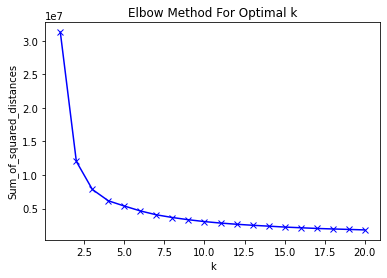

In [40]:
# Generate elbow-method diagram

#define function to find the best k number        
def fitting(df):
    Sum_of_squared_distances = []
    K = range(1,21)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(df)
        Sum_of_squared_distances.append(km.inertia_)
        #inertia_ reports the within group sum of squared errors, which is W in this Jupyter.
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    return 

fitting(stp_dummy)

In [41]:
## Best

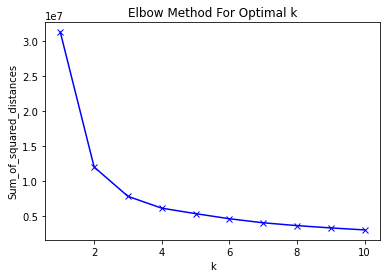

In [42]:
def fitting2(df):
    Sum_of_squared_distances = []
    K = range(1,11)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(df)
        Sum_of_squared_distances.append(km.inertia_)
        #inertia_ reports the within group sum of squared errors, which is W in this Jupyter.
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    return 

fitting2(stp_dummy)

### K-means Model 2 (scale+dummy)

In [43]:
scaler = preprocessing.StandardScaler()
stp_scale_cols = pd.DataFrame(scaler.fit_transform(stp_dummy[['age','weekly_consumption_hour']])).rename(columns={0:'age_scale',1:'weekly_consumption_hour_scale'})
stp_dummy_reindex = stp_dummy.reset_index(drop=True)
stp_scale_dummy_total = pd.concat([stp_scale_cols,stp_dummy_reindex],axis=1) # for reference
stp_scale_dummy = pd.concat([stp_scale_cols,stp_dummy_reindex.iloc[:,2:]],axis=1)

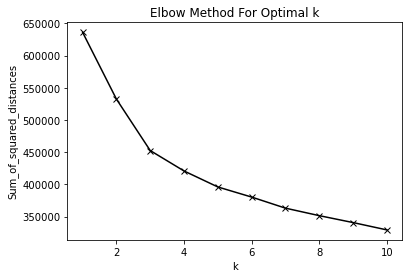

In [818]:
def fitting3(df):
    Sum_of_squared_distances = []
    K = range(1,11)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(df)
        Sum_of_squared_distances.append(km.inertia_)
        #inertia_ reports the within group sum of squared errors, which is W in this Jupyter.
    plt.plot(K, Sum_of_squared_distances, 'kx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    return 

fitting3(stp_scale_dummy)

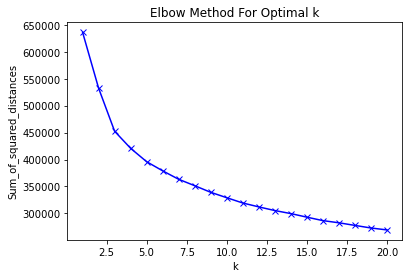

In [44]:
fitting(stp_scale_dummy)

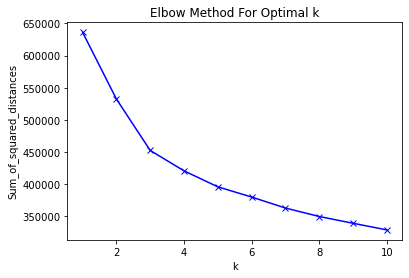

In [45]:
fitting2(stp_scale_dummy)

### K-means Model 3 (All dummy)

In [46]:
# This one does not make sense the results so i commented them

In [47]:
# stp_segment = stp.copy()

# # add range to age so can to_dummy
# col = 'age'
# conditions = [(stp_segment[col] > 13) & (stp_segment[col] <= 20),
#               (stp_segment[col] > 20) & (stp_segment[col] <= 40),
#               (stp_segment[col] > 40) & (stp_segment[col] <= 60),
#               (stp_segment[col] > 60)]
# choices = ["teenagers", 'adults', 'middle_aged_adults', 'retired']
# stp_segment['age_range'] = np.select(conditions, choices)
# stp_segment['age_range'].isna().value_counts()

# #check range of consumption hour

# print(min(stp_segment['weekly_consumption_hour']))
# print(max(stp_segment['weekly_consumption_hour']))

# stp_segment_scat = stp_segment['weekly_consumption_hour'].value_counts().reset_index().rename(
#     columns={
#         'index': 'weekly_consumption_hour',
#         'weekly_consumption_hour': 'count'
#     })

# sns.scatterplot(data=stp_segment_scat, x='weekly_consumption_hour', y='count')

# # add range to wch so can to_dummy
# col = 'weekly_consumption_hour'
# conditions = [(stp_segment[col] <= 15),
#               (stp_segment[col] > 15) & (stp_segment[col] <= 25),
#               (stp_segment[col] > 25) & (stp_segment[col] <= 40),
#               (stp_segment[col] > 40)]
# choices = ["light", 'medium', 'heavy', 'superfans']
# stp_segment['weekly_consumption_hour_range'] = np.select(conditions, choices)

# # only keep dummy columns
# stp_segment = stp_segment.iloc[:,[1,2,3,4,5,7,8]]

# # make dummy
# stp_segment_dummy = pd.get_dummies(stp_segment)

In [48]:
# fitting2(stp_segment_dummy)
# kmeans5 = KMeans(n_clusters=5, random_state=666, max_iter=1000,init='k-means++').fit(stp_segment_dummy)
# print(kmeans5.cluster_centers_)

### K-means Model 4 (engage)

In [789]:
stp_4 = sub[[
    'subid', 'age', 'male_TF', 'op_sys', 'package_type', 'preferred_genre',
    'intended_use', 'weekly_consumption_hour'
]]

stp_4 = stp_4.dropna(subset=['op_sys'])
stp_4 = stp_4.dropna(subset=['package_type'])
stp_4 = stp_4.dropna(subset=['preferred_genre'])
stp_4 = stp_4.dropna(subset=['intended_use'])
stp_4 = stp_4.dropna(subset=['weekly_consumption_hour'])

eng_4 = engage.iloc[:, [0, 2, 4, 5, 6, 7]]
eng_4 = eng_4.groupby('subid').mean().reset_index()

stp_eng = eng_4.merge(stp_4, on='subid',
                      how='left').dropna().reset_index(drop=True)

stp_eng_dummy = pd.get_dummies(stp_eng,
                               columns=[
                                   'male_TF', 'op_sys', 'package_type',
                                   'preferred_genre', 'intended_use'
                               ],
                               prefix=[
                                   'gender_is', 'op_sys_is', 'package_type_is',
                                   'preferred_genre_is', 'intended_use_is'
                               ])

stp_eng_dummy = stp_eng_dummy.rename(columns={
    'gender_is_False': 'Female',
    'gender_is_True': 'Male'
})

scaler = preprocessing.StandardScaler()

stp_eng_dummy_scale_cols = pd.DataFrame(
    scaler.fit_transform(stp_eng_dummy[[
        'app_opens', 'num_videos_completed', 'num_videos_more_than_30_seconds',
        'num_videos_rated', 'num_series_started', 'age',
        'weekly_consumption_hour'
    ]])).rename(
        columns={
            0: 'app_opens_scale',
            1: 'num_videos_completed_scale',
            2: 'num_videos_more_than_30_seconds_scale',
            3: 'num_videos_rated_scale',
            4: 'num_series_started_scale',
            5: 'age_scale',
            6: 'weekly_consumption_hour_scale'
        })

stp_eng_dummy_reindex = stp_eng_dummy.reset_index(drop=True)

stp_eng_scale_dummy_total = pd.concat([stp_eng_dummy_scale_cols, stp_eng_dummy_reindex],
                                  axis=1)  # for reference
stp_eng_scale_dummy = pd.concat([stp_eng_dummy_scale_cols, stp_eng_dummy_reindex.iloc[:, 8:]],
                            axis=1)

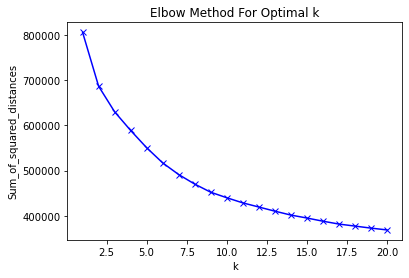

In [793]:
fitting(stp_eng_scale_dummy)

In [801]:
kmeans_eng = KMeans(n_clusters=3, random_state=666, max_iter=1000,init='k-means++').fit(stp_eng_scale_dummy)
label = pd.DataFrame(kmeans_eng.labels_,columns=['cluster'])
model4_km = pd.concat([stp_eng_scale_dummy_total.reset_index(drop=True),label],axis=1)

In [807]:
pd.options.display.max_columns = 50
model4_km.groupby('cluster').mean().to_csv('model4_20211211_0242am.csv')

## Findings (model2)

Both scale/unscale -> elbow = 3
will use 3 as number of clusters
will use 'stp_scale_dummy' as df b/c smaller ssd

In [49]:
kmeans3 = KMeans(n_clusters=3, random_state=666, max_iter=1000,init='k-means++').fit(stp_scale_dummy)
label = pd.DataFrame(kmeans3.labels_,columns=['cluster'])
model2_km = pd.concat([stp_scale_dummy.reset_index(drop=True),label],axis=1)
print(kmeans3.cluster_centers_)

[[-8.49014169e-01 -3.04588245e-01  9.82133045e-01  1.78669553e-02
   3.31662643e-01  6.68337357e-01  5.02522688e-01  5.99450504e-02
   4.37532262e-01  7.06302556e-01  1.78369828e-01  2.46940305e-02
   2.27458163e-02  6.78877695e-02  3.88027641e-01  9.99084173e-05
   4.49587878e-04  4.66239281e-04  1.98651236e-02  4.33519274e-01
   1.57572225e-01]
 [ 8.73220678e-01 -3.83243599e-01  9.82244702e-01  1.77552978e-02
   3.67123049e-01  6.32876951e-01  6.25848086e-01  1.29728787e-01
   2.44423127e-01  5.97523328e-01  2.96154182e-01  4.62021453e-02
   2.55690242e-02  3.45513212e-02  5.01892387e-01  6.62771431e-04
   1.69181128e-03  1.77901805e-03  4.95334438e-02  3.01735415e-01
   1.42705154e-01]
 [ 3.48080377e-02  1.52105314e+00  3.44363856e-01  6.55636144e-01
   3.59474161e-01  6.40525839e-01  5.22816561e-01  1.05734361e-01
   3.71449078e-01  5.38833484e-01  3.13312179e-01  4.50287096e-02
   2.85584769e-02  7.42671502e-02  4.65397401e-01  1.51103052e-04
   3.39981868e-04  4.91084920e-04  2.2

In [50]:
stp_scale_dummy

,age_scale,weekly_consumption_hour_scale,Female,Male,op_sys_is_Android,op_sys_is_iOS,package_type_is_base,package_type_is_economy,package_type_is_enhanced,preferred_genre_is_comedy,...,preferred_genre_is_international,preferred_genre_is_other,preferred_genre_is_regional,intended_use_is_access to exclusive content,intended_use_is_education,intended_use_is_expand international access,intended_use_is_expand regional access,intended_use_is_other,intended_use_is_replace OTT,intended_use_is_supplement OTT
0,-1.487393,1.614713,0,1,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
1,-1.125456,-1.630928,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-1.270231,-1.040811,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1.118550,-1.630928,1,0,1,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,-1.632167,1.319655,1,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143857,-0.184421,-0.745753,1,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
143858,-0.546358,0.139422,1,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
143859,0.249903,-0.155636,1,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
143860,-0.039647,0.729539,1,0,0,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [51]:
stp_scale_dummy_total[[
    'age_scale', 'age'
]].sort_values(by='age_scale').reset_index(drop=True).iloc[32250]

age_scale    -0.908294
age          33.000000
Name: 32250, dtype: float64

In [52]:
pd.set_option('display.max_rows', 100)

stp_scale_dummy_total[['age_scale',
                       'age']].value_counts().reset_index().sort_values(
                           by='age_scale').reset_index(drop=True)

,age_scale,age,0
0,-2.138878,16.000000,1
1,-1.994104,18.000000,940
2,-1.921716,19.000000,535
3,-1.849329,20.000000,1068
4,-1.776942,21.000000,1043
5,-1.704555,22.000000,1402
6,-1.673648,22.426967,1
7,-1.632167,23.000000,1751
8,-1.559780,24.000000,1930
9,-1.487393,25.000000,2164


In [53]:
stp_scale_dummy_total[['weekly_consumption_hour_scale',
                       'weekly_consumption_hour']].value_counts().reset_index().sort_values(
                           by='weekly_consumption_hour_scale').reset_index(drop=True)

,weekly_consumption_hour_scale,weekly_consumption_hour,0
0,-5.171627,2.652191,6
1,-4.876569,4.102148,2
2,-4.581511,5.552104,5
3,-4.286452,7.002060,14
4,-3.991394,8.452017,16
5,-3.696336,9.901973,20
6,-3.401277,11.351929,6
7,-3.106219,12.801885,17
8,-2.811161,14.251842,43
9,-2.516103,15.701798,157


In [54]:
model2_km.groupby('cluster').mean()

,age_scale,weekly_consumption_hour_scale,Female,Male,op_sys_is_Android,op_sys_is_iOS,package_type_is_base,package_type_is_economy,package_type_is_enhanced,preferred_genre_is_comedy,...,preferred_genre_is_international,preferred_genre_is_other,preferred_genre_is_regional,intended_use_is_access to exclusive content,intended_use_is_education,intended_use_is_expand international access,intended_use_is_expand regional access,intended_use_is_other,intended_use_is_replace OTT,intended_use_is_supplement OTT
cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.848889,-0.304736,0.982216,0.017784,0.331746,0.668254,0.502556,0.059995,0.437449,0.706219,...,0.024694,0.022762,0.067904,0.388044,0.000100,0.000450,0.000466,0.019865,0.433469,0.157606
1,0.873292,-0.383041,0.982211,0.017789,0.367052,0.632948,0.625868,0.129670,0.244463,0.597527,...,0.046200,0.025585,0.034550,0.501849,0.000663,0.001692,0.001779,0.049531,0.301685,0.142802
2,0.034275,1.521165,0.344176,0.655824,0.359439,0.640561,0.522687,0.105746,0.371567,0.539008,...,0.045034,0.028486,0.074238,0.465450,0.000151,0.000340,0.000491,0.022819,0.369035,0.141713


In [822]:
model2_km2 = pd.concat([stp_scale_dummy_total.reset_index(drop=True),label],axis=1)



model2_km2

,age_scale,weekly_consumption_hour_scale,age,weekly_consumption_hour,Female,Male,op_sys_is_Android,op_sys_is_iOS,package_type_is_base,package_type_is_economy,package_type_is_enhanced,preferred_genre_is_comedy,preferred_genre_is_drama,preferred_genre_is_international,preferred_genre_is_other,preferred_genre_is_regional,intended_use_is_access to exclusive content,intended_use_is_education,intended_use_is_expand international access,intended_use_is_expand regional access,intended_use_is_other,intended_use_is_replace OTT,intended_use_is_supplement OTT,cluster
0,-1.487393,1.614713,25.0,36.001186,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,2.0
1,-1.125456,-1.630928,30.0,20.051667,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2.0
2,-1.270231,-1.040811,28.0,22.951579,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2.0
3,1.118550,-1.630928,61.0,20.051667,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1.0
4,-1.632167,1.319655,23.0,34.551230,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143857,-0.184421,-0.745753,43.0,24.401536,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,NaN
143858,-0.546358,0.139422,38.0,28.751405,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,NaN
143859,0.249903,-0.155636,49.0,27.301448,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,NaN
143860,-0.039647,0.729539,45.0,31.651317,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,NaN


In [825]:
model2_km.groupby('cluster').mean()

,age_scale,weekly_consumption_hour_scale,Female,Male,op_sys_is_Android,op_sys_is_iOS,package_type_is_base,package_type_is_economy,package_type_is_enhanced,preferred_genre_is_comedy,preferred_genre_is_drama,preferred_genre_is_international,preferred_genre_is_other,preferred_genre_is_regional,intended_use_is_access to exclusive content,intended_use_is_education,intended_use_is_expand international access,intended_use_is_expand regional access,intended_use_is_other,intended_use_is_replace OTT,intended_use_is_supplement OTT
cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.848889,-0.304736,0.982216,0.017784,0.331746,0.668254,0.502556,0.059995,0.437449,0.706219,0.178420,0.024694,0.022762,0.067904,0.388044,0.000100,0.000450,0.000466,0.019865,0.433469,0.157606
1,0.873292,-0.383041,0.982211,0.017789,0.367052,0.632948,0.625868,0.129670,0.244463,0.597527,0.296139,0.046200,0.025585,0.034550,0.501849,0.000663,0.001692,0.001779,0.049531,0.301685,0.142802
2,0.034275,1.521165,0.344176,0.655824,0.359439,0.640561,0.522687,0.105746,0.371567,0.539008,0.313234,0.045034,0.028486,0.074238,0.465450,0.000151,0.000340,0.000491,0.022819,0.369035,0.141713


# Allocation

## Data

In [55]:
# Attribution
# print(sub['attribution_technical'].value_counts()) # entrance to sign-up form captured by product
# print(sub['attribution_survey'].value_counts()) # "how did you hear about us", self-reported upon signup

In [56]:
attr = sub[['account_creation_date','attribution_technical','attribution_survey']]

In [57]:
attr

,account_creation_date,attribution_technical,attribution_survey
380374,2020-03-01 15:44:35,facebook,facebook
496617,2019-12-07 16:37:06,organic,facebook
356799,2020-01-27 16:09:32,search,tv
681701,2019-10-05 12:57:07,discovery,youtube
284782,2020-03-03 20:15:43,bing,tv
...,...,...,...
603751,2020-01-01 22:43:56,email,pinterest
509326,2019-11-17 14:12:33,facebook,facebook_organic
229587,2019-12-06 18:02:13,google_organic,referral
281340,2019-12-21 19:40:44,facebook,facebook


## Preprocessing

In [58]:
# Attribution df cleaning

In [60]:
attr_pro = attr.copy()

# 1. create 3 individual columns: month&year, mo, year
attr_pro['creation_ym'] = pd.to_datetime(attr['account_creation_date']).dt.to_period('M')
attr_pro['creation_year'] = pd.to_datetime(attr['account_creation_date']).dt.to_period('Y')
attr_pro['creation_month'] = attr['account_creation_date'].dt.month

# 2. remove unneeded columns
attr_pro = attr_pro.iloc[:,1:]

# 3. pivoting 
attr_pivot = attr_pro[[
    'creation_ym', 'attribution_technical'
]].value_counts().reset_index().rename(columns={0: 'count'})

attr_pivot = attr_pivot.pivot(index='creation_ym', columns='attribution_technical', values='count').reset_index()

# 4. check columns and only keep the ones we want that match the spend df.
# attr_pivot.info()
attr_pivot = attr_pivot.iloc[:,[0,14,15,12,29,6,1,13,22,23,27]].fillna(0)

# # 5. merge numbers
# i = 0
# while i < len(attr_pivot):
#     attr_pivot['facebook'][i] = attr_pivot['facebook'][i] + attr_pivot['facebook_organic'][i]
#     attr_pivot['pinterest'][i] = attr_pivot['pinterest'][i] + attr_pivot['pinterest_organic'][i]
#     i += 1

# 6. select needed columns, rename, finalize
attr_pivot = attr_pivot.iloc[:, [0, 1, 3, 4, 5, 6, 7, 8, 10]].rename(
    columns={
        'creation_ym': 'date',
        'facebook': 'fb',
        'brand sem intent google': 'brand_sem_intent_google'
    })

<ipython-input-60-ba4fa4d0fcfc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attr_pivot['facebook'][i] = attr_pivot['facebook'][i] + attr_pivot['facebook_organic'][i]
<ipython-input-60-ba4fa4d0fcfc>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attr_pivot['pinterest'][i] = attr_pivot['pinterest'][i] + attr_pivot['pinterest_organic'][i]


In [61]:
attr_pivot

attribution_technical,date,fb,email,search,brand_sem_intent_google,affiliate,email_blast,pinterest,referral
0,2019-06,1335.0,308.0,106.0,197.0,78.0,108.0,36.0,22.0
1,2019-07,10217.0,3228.0,1315.0,2075.0,828.0,1500.0,791.0,521.0
2,2019-08,8210.0,2551.0,1714.0,1627.0,1809.0,1626.0,599.0,413.0
3,2019-09,5371.0,1879.0,1588.0,1235.0,938.0,1298.0,471.0,431.0
4,2019-10,7356.0,1811.0,2006.0,1290.0,733.0,808.0,633.0,393.0
5,2019-11,9820.0,1977.0,2126.0,1641.0,473.0,514.0,545.0,440.0
6,2019-12,7033.0,2074.0,3245.0,2019.0,524.0,333.0,789.0,516.0
7,2020-01,4839.0,1842.0,3501.0,2221.0,991.0,27.0,747.0,424.0
8,2020-02,6296.0,2590.0,3776.0,2011.0,1397.0,55.0,631.0,439.0
9,2020-03,5272.0,2835.0,2695.0,1497.0,1537.0,51.0,419.0,401.0


In [87]:
#attr_sum = 
attr_pivot.iloc[1:,:].sum().to_frame().T

attribution_technical,fb,email,search,brand_sem_intent_google,affiliate,email_blast,pinterest,referral
0,64414.0,20787.0,21966.0,15616.0,9230.0,6212.0,5625.0,3978.0


In [62]:
# spend df
spend_pro = spend.copy()

In [63]:
spend_pro

,date,fb,email,search,brand_sem_intent_google,affiliate,email_blast,pinterest,referral
0,2019-06-30 00:00:00,84800,75000,17300,21400,11900,10500,5900,6100
1,2019-07-31 00:00:00,60000,75600,17300,21300,12000,29800,6000,6600
2,2019-08-31 00:00:00,52300,76100,18100,21300,16300,65900,6200,6800
3,2019-09-30 00:00:00,49000,75800,18900,21300,16400,73700,6000,7400
4,2019-10-31 00:00:00,51300,76000,21000,21400,12200,32300,6700,7300
5,2019-11-30 00:00:00,56100,75900,21400,21600,11700,9800,6300,7300
6,2019-12-31 00:00:00,51400,76100,32100,22200,12100,3500,7200,8000
7,2020-01-31 00:00:00,49000,75500,33600,22700,14300,300,6700,7400
8,2020-02-29 00:00:00,49700,76600,30100,21700,15000,300,6400,6500
9,2020-03-31 00:00:00,49100,78000,22700,21200,17600,300,5900,10000


In [88]:
spend_pro.iloc[:-1,:].sum().to_frame().T

,fb,email,search,brand_sem_intent_google,affiliate,email_blast,pinterest,referral
0,503600,682600,209800,194900,121900,226100,57400,63400


## average CAC

In [64]:
# remove first/last row b/c they pay money at 6/30 for july, so the data should move down one row
cac = spend_pro.iloc[:-1,1:].reset_index(drop=True).div(attr_pivot.iloc[1:,1:].reset_index(drop=True),axis=0)

In [93]:
spend_pro.iloc[:-1, :].sum().to_frame().T.div(
    attr_pivot.iloc[1:, :].sum().to_frame().T,
    axis=0).T.reset_index().rename(columns={
        'index': 'channel',
        0: 'avg_cac'
    }).sort_values(by='avg_cac').reset_index(drop=True)

,channel,avg_cac
0,fb,7.818176
1,search,9.551124
2,pinterest,10.204444
3,brand_sem_intent_google,12.480789
4,affiliate,13.206934
5,referral,15.937657
6,email,32.837831
7,email_blast,36.397296


In [65]:
cac

,fb,email,search,brand_sem_intent_google,affiliate,email_blast,pinterest,referral
0,8.299892,23.234201,13.155894,10.313253,14.371981,7.0,7.458913,11.708253
1,7.308161,29.635437,10.093349,13.09158,6.633499,18.327183,10.016694,15.98063
2,9.737479,40.500266,11.397985,17.246964,17.377399,50.770416,13.163482,15.777262
3,6.661229,41.855329,9.421735,16.511628,22.373806,91.212871,9.478673,18.829517
4,5.224033,38.442084,9.877705,13.040829,25.792812,62.840467,12.293578,16.590909
5,7.976681,36.59595,6.594761,10.698366,22.328244,29.429429,7.984791,14.147287
6,10.622029,41.313789,9.168809,9.995498,12.209889,129.62963,9.638554,18.867925
7,7.782719,29.150579,8.898305,11.287916,10.23622,5.454545,10.618067,16.856492
8,9.427162,27.0194,11.168831,14.495658,9.759271,5.882353,15.274463,16.209476


In [66]:
cac.mean().reset_index().rename(columns={
    'index': 'channel',
    0: 'avg_cac'
}).sort_values(by='avg_cac').reset_index(drop=True)

,channel,avg_cac
0,fb,8.115487
1,search,9.975264
2,pinterest,10.658579
3,brand_sem_intent_google,12.964632
4,affiliate,15.675902
5,referral,16.107528
6,email,34.194115
7,email_blast,44.505211


# Churn

In [67]:
pd.options.display.max_columns = 25

## Functions

In [68]:
# ------ DEFINE FUNCTIONS -----
def apply_offers(df, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn):
    df_f = copy.deepcopy(df)

    # set offer parameters for all observations
    df_f['price_no_offer'] = base_price
    df_f.loc[df_f['churn_TF'] == 1, 'price_no_offer'] = 0  # if the person churns they will pay 0

    # determine whether indiviudals accept offer
    df_f.loc[df_f['churn_TF'] == 1, 'accept_offer_prob'] = acceptance_rate_churn  # those who were going to churn are less likely to want the offer than those who were going to stay
    df_f.loc[df_f['churn_TF'] == 0, 'accept_offer_prob'] = acceptance_rate_nonchurn
    df_f['would_accept_offer_rand_draw'] = (df_f['random_draws'] < df_f['accept_offer_prob'])  # randomly select the individuals who would accept an offer based on their probability of acceptance

    # make offer under lpm predictions for select threshold
    df_f['make_offer_lpm'] = (df_f['prob_churn_lpm'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_lpm'] = (df_f['make_offer_lpm'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_lpm_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_lpm'], 'price_lpm_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    # make offer under logit predictions for select threshold
    df_f['make_offer_logit'] = (df_f['prob_churn_logit'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_logit'] = (df_f['make_offer_logit'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_logit_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_logit'], 'price_logit_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    df_impact = pd.DataFrame(index=cases, columns=['subs', 'revenue', 'lift_from_no_offer'])
    for c in cases:
        df_impact.loc[c, 'subs'] = (df_f['price_' + c] > 0).sum()
        df_impact.loc[c, 'revenue'] = df_f['price_' + c].sum()
    for c in cases:
        df_impact.loc[c, 'lift_from_no_offer'] = df_impact.loc[c, 'revenue'] / df_impact.loc['no_offer', 'revenue'] - 1

    return df_f, df_impact

In [69]:
def get_gini_info(actual, pred_prob):
    # format[[obs0_pred0, obs0_pred1], [obs1_pred0, obs1_pred1]]; rows (i) are observed, columns (j) are predicted
    confusion_matrix_list = list()
    for t in [x / 100 for x in range(0, 100, 33)]:
        pred = [1 if (x > t) else 0 for x in pred_prob]
        confusion_matrix_list.append(confusion_matrix(actual, pred))
        # confusion_matrix_list.append(model.pred_table(threshold=t))

    # create Gini coefficient plots
    false_positives = list()
    true_positives = list()
    for t in confusion_matrix_list:
        true_positives.append(t[1, 1])
        false_positives.append(t[0, 1])

    return confusion_matrix_list, false_positives, true_positives

### NO USE

In [70]:
# sub.info()

In [71]:
# first part from sub df, then clean nan value and add churn tf value
churn1 = sub.iloc[:,[0,8,5,7,9,20]].reset_index(drop=True)

# churn1.info()

# subid -> for merge data  
# age -> continious variable; NO CHANGE
# retarget_TF -> 1 if this person was a previous subscriber who had churned; CHANGE TO 1/0
# male_TF -> 1 male, 0 female; CHANGE TO 1/0
# cancel_before_trial_end -> 1 if cancelled; CHANGE TO 1/0

churn1['male_TF'] = churn1['male_TF'].apply(lambda x: int(x))
churn1['retarget_TF'] = churn1['retarget_TF'].apply(lambda x: int(x))
churn1['cancel_before_trial_end'] = churn1['cancel_before_trial_end'].apply(lambda x: int(x))

churn1.dropna(inplace=True)
churn1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188704 entries, 0 to 191456
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   subid                    188704 non-null  int64  
 1   age                      188704 non-null  float64
 2   weekly_consumption_hour  188704 non-null  float64
 3   retarget_TF              188704 non-null  int64  
 4   male_TF                  188704 non-null  int64  
 5   cancel_before_trial_end  188704 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 10.1 MB


In [72]:
# second part from engage df, take average, then clean nan value
churn2 = engage.iloc[:,[0,2,4,5,6,7]]
churn2 = churn2.groupby('subid').mean().reset_index()

In [518]:
churn2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135019 entries, 0 to 135018
Data columns (total 6 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   subid                            135019 non-null  int64  
 1   app_opens                        135019 non-null  float64
 2   num_videos_completed             135019 non-null  float64
 3   num_videos_more_than_30_seconds  135019 non-null  float64
 4   num_videos_rated                 135019 non-null  float64
 5   num_series_started               135019 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 6.2 MB


In [ ]:
# third part is indicator churn TF - Y variable

In [520]:
# check each subid only has either churn/no churn so i can extract id and current_sub_tf
assert len(rep[['subid','current_sub_TF']].value_counts().reset_index()['subid'].unique()) == rep[['subid','current_sub_TF']].value_counts().reset_index().shape[0]

In [535]:
churn3 = rep[['subid','current_sub_TF']].value_counts().reset_index()
churn3 = churn3[['subid','current_sub_TF']]

#b/c y is churntf so switch false and true
churn3['current_sub_TF'] = churn3['current_sub_TF'].apply(lambda x: -999 if x == False else 111)
# -999 means unsubscribed (true for churn_tf now); 111 means subscriber (so no churn false)
churn3['current_sub_TF'] = churn3['current_sub_TF'].apply(lambda x: True if x == -999 else False)
churn3 = churn3.rename(columns = {'current_sub_TF':'churn_TF'})

In [ ]:
# NOW JOIN!!

In [541]:
churn12 = churn1.merge(churn2,on="subid",how="left").dropna()#['app_opens'].isna().value_counts()
churn = churn12.merge(churn3,on="subid",how="left").dropna()

In [540]:
churn

(110443, 12)

In [543]:
churn['churn_TF'].value_counts()

True     93218
False    17225
Name: churn_TF, dtype: int64

In [549]:
churn.columns

Index(['subid', 'age', 'weekly_consumption_hour', 'retarget_TF', 'male_TF',
       'cancel_before_trial_end', 'app_opens', 'num_videos_completed',
       'num_videos_more_than_30_seconds', 'num_videos_rated',
       'num_series_started', 'churn_TF'],
      dtype='object')

In [545]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110443 entries, 0 to 110442
Data columns (total 12 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   subid                            110443 non-null  int64  
 1   age                              110443 non-null  float64
 2   weekly_consumption_hour          110443 non-null  float64
 3   retarget_TF                      110443 non-null  int64  
 4   male_TF                          110443 non-null  int64  
 5   cancel_before_trial_end          110443 non-null  int64  
 6   app_opens                        110443 non-null  float64
 7   num_videos_completed             110443 non-null  float64
 8   num_videos_more_than_30_seconds  110443 non-null  float64
 9   num_videos_rated                 110443 non-null  float64
 10  num_series_started               110443 non-null  float64
 11  churn_TF                         110443 non-null  bool   
dtypes:

,age,weekly_consumption_hour,retarget_TF,male_TF,cancel_before_trial_end,app_opens,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,churn_TF
age,1.000000,-0.031305,0.007570,0.031536,0.066595,0.001271,-0.103940,0.001769,0.078785,0.010944,-0.097562
weekly_consumption_hour,-0.031305,1.000000,-0.022363,0.560573,0.075948,0.006655,-0.029154,-0.025855,-0.000243,0.010226,-0.090913
retarget_TF,0.007570,-0.022363,1.000000,-0.035977,0.015191,0.004551,0.004315,-0.010293,0.014417,0.018819,-0.010606
male_TF,0.031536,0.560573,-0.035977,1.000000,0.110944,-0.006590,-0.076205,-0.037614,-0.001399,-0.002423,-0.141985
cancel_before_trial_end,0.066595,0.075948,0.015191,0.110944,1.000000,0.052852,-0.065245,-0.252200,0.315578,0.238819,-0.584130
app_opens,0.001271,0.006655,0.004551,-0.006590,0.052852,1.000000,0.310786,0.143108,0.062896,0.350558,-0.087898
num_videos_completed,-0.103940,-0.029154,0.004315,-0.076205,-0.065245,0.310786,1.000000,0.439797,0.168188,0.557377,0.011516
num_videos_more_than_30_seconds,0.001769,-0.025855,-0.010293,-0.037614,-0.252200,0.143108,0.439797,1.000000,-0.058146,0.058834,0.155299
num_videos_rated,0.078785,-0.000243,0.014417,-0.001399,0.315578,0.062896,0.168188,-0.058146,1.000000,0.273355,-0.253766
num_series_started,0.010944,0.010226,0.018819,-0.002423,0.238819,0.350558,0.557377,0.058834,0.273355,1.000000,-0.209967


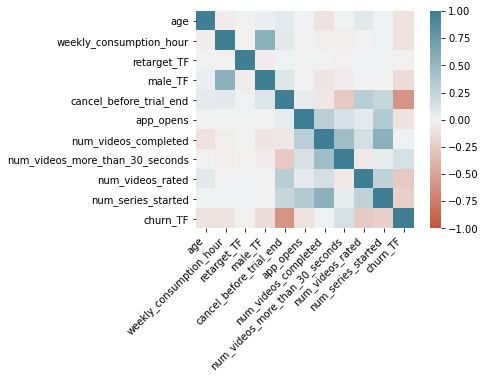

In [548]:
# check correlation
# churn.iloc[:,1:].corr()

corr = churn.iloc[:, [1,2,3,4,5,6,7,8,9,10,11]].corr()
ax = sns.heatmap(corr,
                 vmin=-1,
                 vmax=1,
                 center=0,
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right')

corr

In [491]:
churn['churn_TF'].value_counts()

1    82888
0    28928
Name: churn_TF, dtype: int64

### NO USE

In [346]:
# sub['creation_until_cancel_days'].isna().value_counts()

# # if false then there's a value, so this person already cancelled
# # else if true then there's no cancellation date, this person is still active

False    146694
True      44763
Name: creation_until_cancel_days, dtype: int64

In [507]:
# # first part from sub df, then clean nan value and add churn tf value
# churn1 = sub.iloc[:,[0,8,7,9,20]].reset_index(drop=True)

# # churn1.info()

# # subid -> for merge data  
# # age -> continious variable; NO CHANGE
# # retarget_TF -> 1 if this person was a previous subscriber who had churned; CHANGE TO 1/0
# # male_TF -> 1 male, 0 female; CHANGE TO 1/0
# # cancel_before_trial_end -> 1 if cancelled; CHANGE TO 1/0

# # creation_until_cancel_days -> if nan then no churn & 0, if has value then churn & 1; CHANGE TO 1/0
# # # change ↓ this column to churn T/F (True is churn and False is no churn or still customer)
# # churn1['creation_until_cancel_days'] = churn1['creation_until_cancel_days'].fillna(-999)
# # churn1['creation_until_cancel_days'] = churn1['creation_until_cancel_days'].apply(lambda x: 1 if x != -999 else 0)
# # churn1 = churn1.rename(columns = {'creation_until_cancel_days':'churn_TF'})

# churn1['male_TF'] = churn1['male_TF'].apply(lambda x: int(x))
# churn1['retarget_TF'] = churn1['retarget_TF'].apply(lambda x: int(x))
# churn1['cancel_before_trial_end'] = churn1['cancel_before_trial_end'].apply(lambda x: int(x))

## Data Preprocessing

In [338]:
#sub.info()

In [339]:
#churn_sub.info()

In [96]:
#  0   subid                         # for merge data
#  1   num_weekly_services_utilized  # continuous
#  2   weekly_consumption_hour       # continuous
#  3   age                           # continuous
#  4   monthly_price                 # continuous
#  5   join_fee                      # continuous
#  6   package_type                  # to dummy (multiple)
#  7   preferred_genre               # to dummy (multiple)
#  8   intended_use                  # to dummy (multiple)
#  9   retarget_TF                   # to 1(retarget) or 0(not retarget)
#  10  male_TF                       # to 1(male) or 0(female)
#  11  op_sys                        # to 1(android) or 0(ios)
#  12  cancel_before_trial_end       # to 1(cancelled) or 0(not cancelled)
#  13  refund_after_trial_TF         # to 1(refund) or 0(not refund)

In [685]:
# first part from sub df, then clean nan value and add churn tf value
churn_sub = sub.iloc[:,[0,      2,5,8,16,24,   1,3,4,7,9,13,20,27 ]].reset_index(drop=True)
#                       subid   continue.      dummy.      

# 1/ remove null rows
churn_sub['num_weekly_services_utilized'] = churn_sub['num_weekly_services_utilized'].fillna(0.0)
churn_sub['weekly_consumption_hour'] = churn_sub['weekly_consumption_hour'].fillna(0.0)
#churn_sub['package_type'] = churn_sub['package_type'].fillna('enhanced')##########
churn_sub['preferred_genre'] = churn_sub['preferred_genre'].fillna('unknown')
churn_sub['intended_use'] = churn_sub['intended_use'].fillna('unknown')

churn_sub.dropna(inplace=True)
churn_sub.reset_index(drop=True,inplace=True)

# 2/ change 1/0
churn_sub['retarget_TF'] = churn_sub['retarget_TF'].apply(lambda x: int(x))#.value_counts()

churn_sub['male_TF'] = churn_sub['male_TF'].apply(lambda x: int(x))
# churn_sub['male_TF'] = churn_sub['male_TF'].apply(lambda x: -999 if x == False else 111)
# churn_sub['male_TF'] = churn_sub['male_TF'].apply(lambda x: True if x == -999 else False)
# churn_sub = churn_sub.rename(columns = {'male_TF':'female_TF'})
# churn_sub['female_TF'] = churn_sub['female_TF'].apply(lambda x: int(x))

churn_sub['op_sys'] = churn_sub['op_sys'].apply(lambda x: 1 if x == 'Android' else 0)
churn_sub['cancel_before_trial_end'] = churn_sub['cancel_before_trial_end'].apply(lambda x: int(x))
churn_sub['refund_after_trial_TF'] = churn_sub['refund_after_trial_TF'].apply(lambda x: int(x))


#add range to age so can to_dummy
col = 'age'
conditions = [(churn_sub[col] > 13) & (churn_sub[col] <= 20),
              (churn_sub[col] > 20) & (churn_sub[col] <= 40),
              (churn_sub[col] > 40) & (churn_sub[col] <= 60),
              (churn_sub[col] > 60)]
choices = ["teenagers", 'adults', 'middle_aged_adults', 'retired']
churn_sub['age'] = np.select(conditions, choices)

# 3/ to_dummy
churn_dummy = pd.get_dummies(churn_sub,
               columns=['preferred_genre','intended_use','package_type','age'],
               prefix=['genre:','use:','package:','age_range:'])

In [684]:
# # first part from sub df, then clean nan value and add churn tf value
# churn_sub = sub.iloc[:,[0,      2,5,8,16,24,   1,3,4,7,9,13,20,27 ]].reset_index(drop=True)
# #                       subid   continue.      dummy.      

# # 1/ remove null rows
# churn_sub['num_weekly_services_utilized'] = churn_sub['num_weekly_services_utilized'].fillna(0.0)
# churn_sub.dropna(inplace=True)
# churn_sub.reset_index(drop=True,inplace=True)

# # 2/ change 1/0
# churn_sub['retarget_TF'] = churn_sub['retarget_TF'].apply(lambda x: int(x))#.value_counts()

# churn_sub['male_TF'] = churn_sub['male_TF'].apply(lambda x: int(x))
# # churn_sub['male_TF'] = churn_sub['male_TF'].apply(lambda x: -999 if x == False else 111)
# # churn_sub['male_TF'] = churn_sub['male_TF'].apply(lambda x: True if x == -999 else False)
# # churn_sub = churn_sub.rename(columns = {'male_TF':'female_TF'})
# # churn_sub['female_TF'] = churn_sub['female_TF'].apply(lambda x: int(x))

# churn_sub['op_sys'] = churn_sub['op_sys'].apply(lambda x: 1 if x == 'Android' else 0)
# churn_sub['cancel_before_trial_end'] = churn_sub['cancel_before_trial_end'].apply(lambda x: int(x))
# churn_sub['refund_after_trial_TF'] = churn_sub['refund_after_trial_TF'].apply(lambda x: int(x))


# #add range to age so can to_dummy
# col = 'age'
# conditions = [(churn_sub[col] > 13) & (churn_sub[col] <= 20),
#               (churn_sub[col] > 20) & (churn_sub[col] <= 40),
#               (churn_sub[col] > 40) & (churn_sub[col] <= 60),
#               (churn_sub[col] > 60)]
# choices = ["teenagers", 'adults', 'middle_aged_adults', 'retired']
# churn_sub['age'] = np.select(conditions, choices)

# # 3/ to_dummy
# churn_dummy = pd.get_dummies(churn_sub,
#                columns=['preferred_genre','intended_use','package_type','age'],
#                prefix=['genre:','use:','package:','age_range:'])

In [686]:
# rep

churn_TF = rep[['subid','current_sub_TF','payment_period']].groupby('subid').max('payment_period').reset_index()
#churn_TF = churn_TF[['subid','current_sub_TF']]

churn_TF['current_sub_TF'] = churn_TF['current_sub_TF'].apply(lambda x: -999 if x == False else 111)
churn_TF['current_sub_TF'] = churn_TF['current_sub_TF'].apply(lambda x: True if x == -999 else False)
churn_TF = churn_TF.rename(columns = {'current_sub_TF':'churn_TF'})

# engagement

churn_eng = engage.iloc[:,[0,2,4,5,6,7]]
churn_eng = churn_eng.groupby('subid').mean().reset_index()

# merge

churn_sub_merge_half = churn_TF.merge(churn_dummy, on='subid', how='left').dropna().reset_index(drop=True)
churn_sub_merge = churn_sub_merge_half.merge(churn_eng, on='subid', how='left').dropna().reset_index(drop=True)

churn_sub_merge['payment_period'] = churn_sub_merge['payment_period'].astype(float)

In [687]:
churn_sub_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86273 entries, 0 to 86272
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   subid                             86273 non-null  int64  
 1   churn_TF                          86273 non-null  bool   
 2   payment_period                    86273 non-null  float64
 3   num_weekly_services_utilized      86273 non-null  float64
 4   weekly_consumption_hour           86273 non-null  float64
 5   monthly_price                     86273 non-null  float64
 6   join_fee                          86273 non-null  float64
 7   retarget_TF                       86273 non-null  float64
 8   male_TF                           86273 non-null  float64
 9   op_sys                            86273 non-null  float64
 10  cancel_before_trial_end           86273 non-null  float64
 11  refund_after_trial_TF             86273 non-null  float64
 12  genr

,payment_period,num_weekly_services_utilized,weekly_consumption_hour,monthly_price,join_fee,app_opens,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started
payment_period,1.000000,0.202320,0.088529,0.016651,0.020490,0.061847,-0.056974,-0.235643,0.343546,0.239731
num_weekly_services_utilized,0.202320,1.000000,0.148694,-0.002238,0.012590,0.187113,0.294937,-0.046699,0.125308,0.669150
weekly_consumption_hour,0.088529,0.148694,1.000000,-0.004785,0.039944,-0.001229,-0.032399,-0.029044,0.004698,0.012089
monthly_price,0.016651,-0.002238,-0.004785,1.000000,-0.025381,-0.008020,-0.009422,-0.013321,0.002262,0.001100
join_fee,0.020490,0.012590,0.039944,-0.025381,1.000000,-0.012644,-0.050971,-0.009314,0.013896,-0.000701
app_opens,0.061847,0.187113,-0.001229,-0.008020,-0.012644,1.000000,0.323799,0.140953,0.059624,0.364884
num_videos_completed,-0.056974,0.294937,-0.032399,-0.009422,-0.050971,0.323799,1.000000,0.429062,0.154346,0.546454
num_videos_more_than_30_seconds,-0.235643,-0.046699,-0.029044,-0.013321,-0.009314,0.140953,0.429062,1.000000,-0.062347,0.037205
num_videos_rated,0.343546,0.125308,0.004698,0.002262,0.013896,0.059624,0.154346,-0.062347,1.000000,0.260348
num_series_started,0.239731,0.669150,0.012089,0.001100,-0.000701,0.364884,0.546454,0.037205,0.260348,1.000000


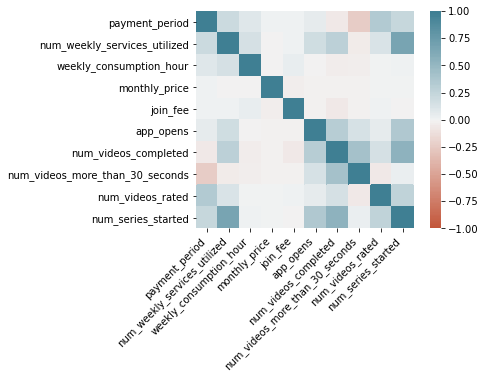

In [688]:
# check correlation
# churn.iloc[:,1:].corr()

corr = churn_sub_merge.iloc[:,[2,3,4,5,6,33,34,35,36,37]].corr()
ax = sns.heatmap(corr,
                 vmin=-1,
                 vmax=1,
                 center=0,
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right')

corr

In [810]:
engage['num_videos_rated'].value_counts()

0.0     2424308
1.0      107745
2.0       15728
3.0        2553
4.0         590
5.0         135
6.0          33
7.0          12
8.0           4
9.0           3
11.0          1
12.0          1
Name: num_videos_rated, dtype: int64

In [839]:
churn_sub_merge.describe()

,subid,payment_period,num_weekly_services_utilized,weekly_consumption_hour,monthly_price,join_fee,retarget_TF,male_TF,op_sys,cancel_before_trial_end,refund_after_trial_TF,genre:_comedy,genre:_drama,genre:_international,genre:_other,genre:_regional,genre:_unknown,use:_access to exclusive content,use:_education,use:_expand international access,use:_expand regional access,use:_other,use:_replace OTT,use:_supplement OTT,use:_unknown,package:_base,package:_economy,package:_enhanced,age_range:_adults,age_range:_middle_aged_adults,age_range:_retired,age_range:_teenagers,app_opens,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started
count,8.627300e+04,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000,86273.000000
mean,2.500014e+07,0.327971,2.131020,27.981819,4.735271,0.137269,0.032432,0.129554,0.341347,0.317805,0.032316,0.627404,0.249035,0.036640,0.025640,0.057573,0.003709,0.449480,0.000464,0.000962,0.001043,0.032328,0.363068,0.147659,0.004996,0.557301,0.096299,0.346400,0.368910,0.455913,0.158265,0.016911,1.814770,2.533814,4.828881,0.013708,0.432653
std,2.886058e+06,0.576805,1.498912,5.045052,0.020001,0.189916,0.177145,0.335814,0.474164,0.465626,0.176839,0.483499,0.432457,0.187876,0.158058,0.232936,0.060790,0.497444,0.021528,0.031002,0.032282,0.176870,0.480887,0.354764,0.070504,0.496709,0.295003,0.475825,0.482512,0.498055,0.364991,0.128940,1.548133,1.639941,1.230223,0.063427,0.361937
min,2.000040e+07,0.000000,0.000000,0.000000,4.000300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.249468e+07,0.000000,0.000000,24.401536,4.734300,0.036700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.142857,4.333333,0.000000,0.000000
50%,2.499692e+07,0.000000,2.546947,27.301448,4.734300,0.036700,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.250000,2.400000,4.823529,0.000000,0.416667
75%,2.751351e+07,1.000000,2.994681,30.201361,4.734300,0.330300,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.189189,3.767442,5.500000,0.000000,0.777778
max,2.999982e+07,3.000000,9.858013,75.150006,5.101300,0.734000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,45.250000,13.000000,15.000000,2.782609,2.000000


## Churn Model

In [690]:
random.seed(666)
df_train, df_test = model_selection.train_test_split(churn_sub_merge, test_size=0.4)

In [691]:
churn_sub_merge.columns

Index(['subid', 'churn_TF', 'payment_period', 'num_weekly_services_utilized',
       'weekly_consumption_hour', 'monthly_price', 'join_fee', 'retarget_TF',
       'male_TF', 'op_sys', 'cancel_before_trial_end', 'refund_after_trial_TF',
       'genre:_comedy', 'genre:_drama', 'genre:_international', 'genre:_other',
       'genre:_regional', 'genre:_unknown', 'use:_access to exclusive content',
       'use:_education', 'use:_expand international access',
       'use:_expand regional access', 'use:_other', 'use:_replace OTT',
       'use:_supplement OTT', 'use:_unknown', 'package:_base',
       'package:_economy', 'package:_enhanced', 'age_range:_adults',
       'age_range:_middle_aged_adults', 'age_range:_retired',
       'age_range:_teenagers', 'app_opens', 'num_videos_completed',
       'num_videos_more_than_30_seconds', 'num_videos_rated',
       'num_series_started'],
      dtype='object')

In [745]:
# ----- FIT CHURN MODEL ------
y_col_name = 'churn_TF'  # specify which column contains outcome variable y. Needs to be coded as binary True/False or 0/1
x_col_name = [
       'num_weekly_services_utilized','payment_period', 
       'weekly_consumption_hour', 'join_fee', 'retarget_TF','monthly_price', 
       'male_TF', 'op_sys', #'cancel_before_trial_end', 'refund_after_trial_TF',
       'genre:_comedy', 'genre:_drama', 'genre:_international', 'genre:_other',
       'genre:_regional','use:_access to exclusive content', 'genre:_unknown', 
       'use:_education', 'use:_expand international access',
       'use:_expand regional access', 'use:_other', 'use:_replace OTT',
       'use:_supplement OTT', 'package:_base','use:_unknown', 
       'package:_economy', 'package:_enhanced', 'age_range:_adults',
       'age_range:_middle_aged_adults', 'age_range:_retired',
       'age_range:_teenagers', 'app_opens', 'num_videos_completed',
       'num_videos_rated',#'num_videos_more_than_30_seconds', 
       'num_series_started'
]  #'cancel_before_trial_end','refund_after_trial_TF', 'monthly_price', 

add_constant_TF = True

# --- preprocess data for model routine format requirements
if add_constant_TF:
    x_col_name.append('const')
    df_train = sm.add_constant(df_train)
    df_test = sm.add_constant(df_test)

In [746]:
# --- fit linear probability model
lpm_model = sm.OLS(endog=df_train[y_col_name], exog=df_train[x_col_name])
lpm_results = lpm_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(lpm_results.summary())


RESULTS OF LOGIT MODEL FITTING

                            OLS Regression Results                            
Dep. Variable:               churn_TF   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     2745.
Date:                Sat, 11 Dec 2021   Prob (F-statistic):               0.00
Time:                        01:54:01   Log-Likelihood:                 922.09
No. Observations:               51763   AIC:                            -1784.
Df Residuals:                   51733   BIC:                            -1519.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [747]:
# --- fit logistic regression
logit_model = sm.Logit(endog=df_train[y_col_name], exog=df_train[x_col_name])
logit_results = logit_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.161693
         Iterations 11

RESULTS OF LOGIT MODEL FITTING

                           Logit Regression Results                           
Dep. Variable:               churn_TF   No. Observations:                51763
Model:                          Logit   Df Residuals:                    51733
Method:                           MLE   Df Model:                           29
Date:                Sat, 11 Dec 2021   Pseudo R-squ.:                  0.6496
Time:                        01:54:02   Log-Likelihood:                -8369.7
converged:                       True   LL-Null:                       -23890.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
num_weekly_services_utilized  

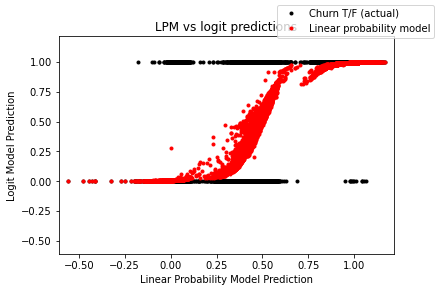

In [748]:
# ----- EVALUATE MODEL PERFORMANCE -----
# --- evaluate model predictions on test set graphically
df_test['prob_churn_lpm'] = lpm_results.predict(df_test[x_col_name])
df_test['prob_churn_logit'] = logit_results.predict(df_test[x_col_name])

# # plot predictions vs. data
# select_plot_coef = [x for x in x_col_name if x != 'const']
# n_rows = 8
# n_cols = math.ceil(len(select_plot_coef) / n_rows)
# fig, axes = plt.subplots(n_rows, n_cols)
# fig.suptitle('Single factor relationship with churn')
# for i in range(n_rows):
#     for j in range(n_cols):
#         select_coef = select_plot_coef[i * n_cols + j]
#         axes[i, j].plot(df_test[select_coef], df_test['churn_TF'], 'k.')
#         axes[i, j].plot(df_test[select_coef], df_test['prob_churn_lpm'], 'b.')
#         axes[i, j].plot(df_test[select_coef], df_test['prob_churn_logit'], 'r.')
#         axes[i, j].set(xlabel=select_coef, ylabel='Churn prob.')
# fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])

# compare lpm and logit predictions
fig = plt.figure()
ax = plt.gca()
ax.plot(df_test[['prob_churn_lpm']], df_test[['churn_TF']], 'k.')
ax.plot(df_test[['prob_churn_lpm']], df_test[['prob_churn_logit']], 'r.')
plt.ylim(df_test[['prob_churn_lpm', 'prob_churn_logit']].min().min()-.05, df_test[['prob_churn_lpm', 'prob_churn_logit']].max().max()+.05)
plt.xlim(ax.get_ylim())
plt.title('LPM vs logit predictions')
plt.xlabel('Linear Probability Model Prediction')
plt.ylabel('Logit Model Prediction')
fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])

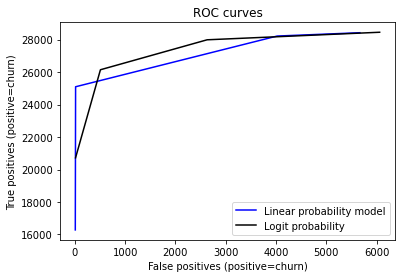

In [840]:
# --- evaluate model predictions using numerical quantification (ROC curves)
# make confusion matrices
logit_conf_mat, logit_false_positives, logit_true_positives = get_gini_info(df_test['churn_TF'], df_test['prob_churn_logit'])
lpm_conf_mat, lpm_false_positives, lpm_true_positives = get_gini_info(df_test['churn_TF'], df_test['prob_churn_lpm'])

# plot ROC curves
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(lpm_false_positives, lpm_true_positives, 'b-')
ax1.plot(logit_false_positives, logit_true_positives, 'k-')
plt.title('ROC curves')
plt.xlabel('False positives (positive=churn)')
plt.ylabel('True positives (positive=churn)')
plt.legend(labels=['Linear probability model', 'Logit probability'])

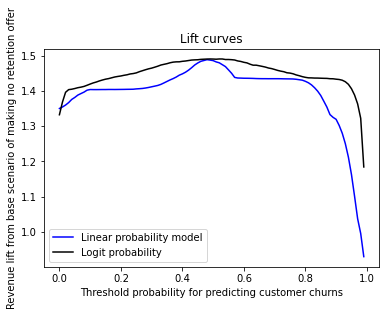

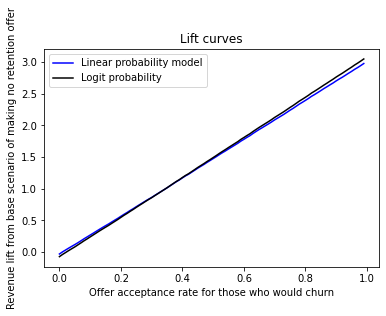

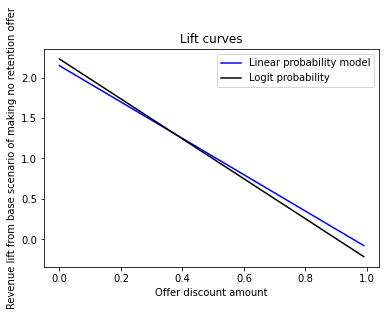

In [849]:
# ----- TEST RETENTION OFFER SCENARIOS -----
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.5
threshold = 0.53
base_price = 4.73
discount_amount = 0.3
cases = ['no_offer', 'lpm_offer', 'logit_offer']

# draw whether individual would accept an offer or not - assume probability of acceptance is independent of offer attractiveness
df_test['random_draws'] = np.random.random(df_test.shape[0])

# base assessment
df_test, df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

# test sensitivity to thresholds
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers(df_test, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind

# test sensitivity to acceptance rate for churners
df_lift_acceptance_rate_churn = pd.DataFrame(index=range(0, 100, 1), columns=['acceptance_rate_churn'] + cases)
for t_ind in df_lift_acceptance_rate_churn.index:
    t_acceptance_rate_churn = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_acceptance_rate_churn.loc[t_ind, 'acceptance_rate_churn'] = t_acceptance_rate_churn
    df_lift_acceptance_rate_churn.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_acceptance_rate_churn, t_ind

# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    t_acceptance_rate_churn = t_discount_amount ** 2
    _, t_df_impact = apply_offers(df_test, threshold, base_price, t_discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind

# --- plot lift curves
# Threshold sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['lpm_offer'], 'b-')
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['logit_offer'], 'k-')
plt.title('Lift curves')
plt.xlabel('Threshold probability for predicting customer churns')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

# Acceptance rate sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['lpm_offer'], 'b-')
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['logit_offer'], 'k-')
plt.title('Lift curves')
plt.xlabel('Offer acceptance rate for those who would churn')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

# Discount amount sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['lpm_offer'], 'b-')
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], 'k-')
plt.title('Lift curves')
plt.xlabel('Offer discount amount')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

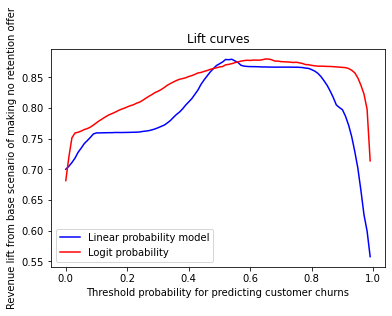

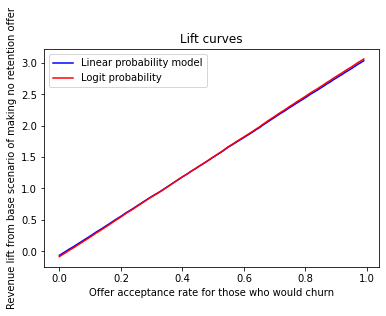

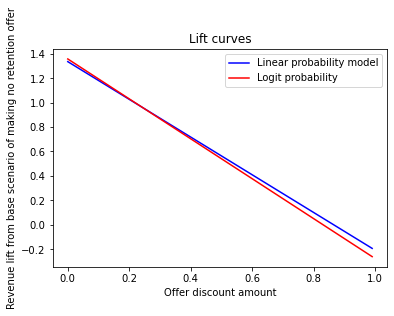

In [837]:
# ----- TEST RETENTION OFFER SCENARIOS -----
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.3
threshold = 0.5
base_price = 4.9
discount_amount = 0.3
cases = ['no_offer', 'lpm_offer', 'logit_offer']

# draw whether individual would accept an offer or not - assume probability of acceptance is independent of offer attractiveness
df_test['random_draws'] = np.random.random(df_test.shape[0])

# base assessment
df_test, df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

# test sensitivity to thresholds
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers(df_test, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind

# test sensitivity to acceptance rate for churners
df_lift_acceptance_rate_churn = pd.DataFrame(index=range(0, 100, 1), columns=['acceptance_rate_churn'] + cases)
for t_ind in df_lift_acceptance_rate_churn.index:
    t_acceptance_rate_churn = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_acceptance_rate_churn.loc[t_ind, 'acceptance_rate_churn'] = t_acceptance_rate_churn
    df_lift_acceptance_rate_churn.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_acceptance_rate_churn, t_ind

# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, t_discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind

# --- plot lift curves
# Threshold sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['lpm_offer'], 'b-')
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Threshold probability for predicting customer churns')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

# Acceptance rate sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['lpm_offer'], 'b-')
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer acceptance rate for those who would churn')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

# Discount amount sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['lpm_offer'], 'b-')
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer discount amount')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

# threshold = ? discount rate = ?

In [835]:
attr1_pro = attr.copy()

# 1. create 3 individual columns: month&year, mo, year
attr1_pro['creation_ym'] = pd.to_datetime(attr['account_creation_date']).dt.to_period('M')
attr1_pro['creation_year'] = pd.to_datetime(attr['account_creation_date']).dt.to_period('Y')
attr1_pro['creation_month'] = attr['account_creation_date'].dt.month

# 2. remove unneeded columns
attr1_pro = attr1_pro.iloc[:,1:]

# 3. pivoting 
attr1_pivot = attr1_pro[[
    'creation_ym', 'attribution_technical'
]].value_counts().reset_index().rename(columns={0: 'count'})

attr1_pivot = attr1_pivot.pivot(index='creation_ym', columns='attribution_technical', values='count').reset_index()
attr1_pivot.columns

Index(['creation_ym', 'affiliate', 'appstore', 'bing', 'bing_organic',
       'brand sem intent bing', 'brand sem intent google', 'content_greatist',
       'criteo', 'direct_mail', 'discovery', 'display', 'email', 'email_blast',
       'facebook', 'facebook_organic', 'google_organic', 'influencer',
       'internal', 'organic', 'other', 'ott', 'pinterest', 'pinterest_organic',
       'playstore', 'podcast', 'quora', 'referral', 'samsung', 'search', 'tv',
       'twitter', 'vod', 'youtube'],
      dtype='object', name='attribution_technical')

In [860]:
# 开始付款
# print(sub['payment_type'].value_counts()) print(sub['initial_credit_card_declined'].value_counts())
## #print(sub['paid_TF'].value_counts()) #T/F user has made a successful payment
# # 使用期间cancellation
#print(sub['cancel_before_trial_end'].value_counts())
print(sub['creation_until_cancel_days'].mean())
# # 使用之后
#print(sub['refund_after_trial_TF'].value_counts()) #T/F user requested refund for 1st period fee after the trial ended and account was charged
# # 收入汇总
print(sub['revenue_net'].mean())

14.159372571475316
1.5559843860501132
